In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17515198450052401484,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 locality {
 }
 incarnation: 11338870430507831593
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2610520485351974555
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14445006029
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12717161655920084946
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# load data

In [2]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

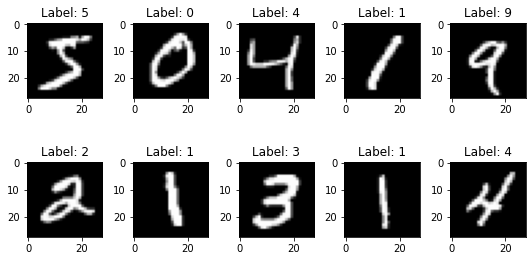

In [4]:
num_row = 2
num_col = 5

# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title('Label: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

# build model

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Flatten

In [6]:
x = Input(shape=(28, 28))  # shape of input
z = Flatten()(x)  # 28x28 -> 784
z = Dense(units=128, activation='relu')(z)  # dense + ReLU
p = Dense(units=10, activation='softmax')(z)  # dense + softmax

model = Model(
    inputs=x,
    outputs=p,
)  # build DNN model

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])  # compile model

In [7]:
# callbacks
callbacks = [
    EarlyStopping(patience=3),
    ModelCheckpoint(filepath=os.path.join('models', 'DNN', 'test.h5'), save_best_only=True),
]

In [8]:
# train
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 2s 32us/sample - loss: 6.0119 - acc: 0.8627 - val_loss: 1.6106 - val_acc: 0.9230
Epoch 2/100
48000/48000 [==============================] - 1s 19us/sample - loss: 1.0599 - acc: 0.9278 - val_loss: 0.9622 - val_acc: 0.9258
Epoch 3/100
48000/48000 [==============================] - 1s 19us/sample - loss: 0.5328 - acc: 0.9415 - val_loss: 0.7926 - val_acc: 0.9348
Epoch 4/100
48000/48000 [==============================] - 1s 19us/sample - loss: 0.3343 - acc: 0.9516 - val_loss: 0.6077 - val_acc: 0.9348
Epoch 5/100
48000/48000 [==============================] - 1s 19us/sample - loss: 0.2412 - acc: 0.9581 - val_loss: 0.5338 - val_acc: 0.9403
Epoch 6/100
48000/48000 [==============================] - 1s 19us/sample - loss: 0.1820 - acc: 0.9649 - val_loss: 0.4968 - val_acc: 0.9415
Epoch 7/100
48000/48000 [==============================] - 1s 18us/sample - loss: 0.1656 - acc: 0.9661 - val_l

In [9]:
# see accuracy

accuracy_score(y_test, model.predict(x_test).argmax(axis=-1))

0.9579

The accuracy of this model is 95.66% (in the author's environment.) Pretty good!

このモデルの精度は（筆者の環境では） 95.66% です。
悪くない！

# compare models

In [10]:
from collections import OrderedDict

class DenseModel:
    def __init__(self, layers=1, hid_dim=128):
        self.input = Input(shape=(28, 28), name='input')
        self.flatten = Flatten(name='flatten')
        self.denses = OrderedDict()
        for i in range(layers):
            name = 'dense_{}'.format(i)
            self.denses[name] = Dense(units=hid_dim, activation='relu', name=name)
        self.last = Dense(units=10, activation='softmax', name='last')
    
    
    def build(self):
        x = self.input
        z = self.flatten(x)
        for dense in self.denses.values():
            z = dense(z)
        p = self.last(z)
        
        model = Model(inputs=x, outputs=p)
        
        return model

In [11]:
dim_hidden_layres = [2**i for i in range(11)]
n_layers = range(1, 4)

df_accuracy = pd.DataFrame()

for layers in n_layers:
    for hid_dim in dim_hidden_layres:
        print('========', 'layers:', layers, '; hid_dim:', hid_dim, '========')
        model = DenseModel(layers=layers, hid_dim=hid_dim)
        model = model.build()
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
        callbacks = [
            EarlyStopping(patience=3),
            ModelCheckpoint(filepath=os.path.join('models', 'DNN', 'model_{}_{}.h5'.format(layers, hid_dim)), save_best_only=True),
        ]
        n_param = model.count_params()
        model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, callbacks=callbacks, validation_split=0.2)
        acc = accuracy_score(y_test, model.predict(x_test).argmax(axis=-1))
        
        df_accuracy = pd.concat([df_accuracy, pd.DataFrame([[layers, hid_dim, n_param, acc]], columns=['layers', 'hid_dim', 'n_param', 'accuracy'])])

======== layers: 1 ; hid_dim: 1 ========
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 1s 23us/sample - loss: 2.3582 - acc: 0.1100 - val_loss: 2.3019 - val_acc: 0.1060
Epoch 2/100
48000/48000 [==============================] - 1s 17us/sample - loss: 2.3014 - acc: 0.1140 - val_loss: 2.3019 - val_acc: 0.1060
Epoch 3/100
48000/48000 [==============================] - 1s 18us/sample - loss: 2.3011 - acc: 0.1140 - val_loss: 2.3021 - val_acc: 0.1060
Epoch 4/100
48000/48000 [==============================] - 1s 17us/sample - loss: 2.3010 - acc: 0.1140 - val_loss: 2.3022 - val_acc: 0.1060
======== layers: 1 ; hid_dim: 2 ========
Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 1s 23us/sample - loss: 2.4564 - acc: 0.1134 - val_loss: 2.3028 - val_acc: 0.1060
Epoch 2/100
48000/48000 [==============================] - 1s 18us/sample - loss: 2.3019 - acc: 0.1139 - val_loss: 2.3

In [18]:
display(df_accuracy.set_index(['layers', 'hid_dim'])[['n_param']].unstack())
display(df_accuracy.set_index(['layers', 'hid_dim'])[['accuracy']].unstack())

n_param                                                         \
hid_dim    1     2     4     8      16     32     64      128     256    
layers                                                                   
1           805  1600  3190  6370  12730  25450  50890  101770  203530   
2           807  1606  3210  6442  13002  26506  55050  118282  269322   
3           809  1612  3230  6514  13274  27562  59210  134794  335114   

                          
hid_dim    512      1024  
layers                    
1        407050   814090  
2        669706  1863690  
3        932362  2913290

accuracy                                                          \
hid_dim     1       2       4       8       16      32      64      128    
layers                                                                     
1         0.1135  0.1135  0.3034  0.8084  0.8856  0.9438  0.9503  0.9521   
2         0.1135  0.1136  0.1135  0.6219  0.9037  0.9368  0.9442  0.9465   
3         0.1135  0.3898  0.1134  0.8490  0.9203  0.9504  0.9592  0.9619   

                                 
hid_dim    256     512     1024  
layers                           
1        0.9583  0.9617  0.9687  
2        0.9671  0.9577  0.9661  
3        0.9583  0.9687  0.9659

In [14]:
df_accuracy.to_csv('dnn_results.csv')